In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
# Styles
plt.style.use('ggplot')
sns.set_style('whitegrid')
# Text Preprocessing
import nltk
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize

In [2]:
dataset = pd.read_csv("spam.csv",encoding='latin-1')
dataset = dataset[["v1","v2"]]
dataset.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:

dataset = dataset.rename(columns={"v1":"label","v2":"text"})
dataset.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print(dataset.info())
print(dataset.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
text     5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB
None
ham     4825
spam     747
Name: label, dtype: int64


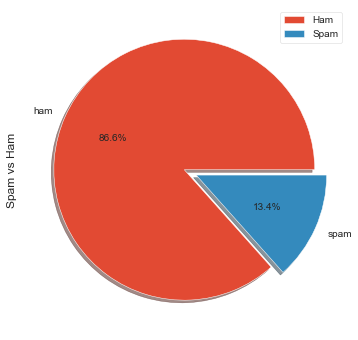

In [5]:
dataset["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()


In [6]:
topMessages = dataset.groupby("text")["label"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)
dataset.drop_duplicates(keep=False, inplace=True)


,len,amax
text,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4,spam
Okie,4,ham
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4,ham


In [7]:
print(dataset.shape)
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")



def cleanText(message):
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    return " ".join(words)


dataset["text"] = dataset["text"].apply(cleanText)
dataset = dataset[["label","text"]]
dataset.head()

(4888, 2)


,label,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think goe usf live around though
5,spam,freemsg hey darl 3 week word back id like fun ...


In [8]:
def train_test_split(dataset): 
    random_val_msk = np.random.rand(len(dataset)) <= 0.8
    X_train = dataset[random_val_msk]
    X_test = dataset[~random_val_msk]
    return X_train, X_test

dataset_train, dataset_test = train_test_split(dataset)
print(dataset_train.head())
print(dataset_test.head())

mask = np.random.rand(len(dataset))<0.8
text_train = dataset.text[mask].values
text_test = dataset.text[~mask].values
label_train = dataset.label[mask].values
label_test = dataset.label[~mask].values
print(len(text_train),len(text_test),len(label_train),len(label_test))

   label                                               text
1    ham                              ok lar joke wif u oni
4    ham          nah dont think goe usf live around though
5   spam  freemsg hey darl 3 week word back id like fun ...
6    ham      even brother like speak treat like aid patent
13   ham  ive search right word thank breather promis wo...
   label                                               text
0    ham  go jurong point crazi avail bugi n great world...
3    ham                u dun say earli hor u c alreadi say
10   ham  im gonna home soon dont want talk stuff anymor...
15  spam  xxxmobilemovieclub use credit click wap link n...
21   ham                    iû÷m go tri 2 month ha ha joke
3958 930 3958 930


In [9]:
messages = dataset.text.values
words_all = []
for message in messages:
    words_all += (message.split(" "))
unique_words = set(words_all)
dictionary_words = {i:words_all.count(i) for i in unique_words}
dictionary_words['hello']

41

In [10]:
spam_messages = dataset.text.values[dataset.label == "spam"]
spam_words = []
for spam in spam_messages:
    spam_words += (spam.split(" "))
unique_spam_words = set(spam_words)
dictionary_spam = {i:spam_words.count(i) for i in unique_spam_words}
dictionary_spam['win']

35

In [11]:
ham_messages = dataset.text.values[dataset.label == "ham"]
ham_words = []
for ham in ham_messages:
    ham_words += (ham.split(" "))
unique_ham_words = set(ham_words)
dictionary_ham = {i:ham_words.count(i) for i in unique_ham_words}
dictionary_ham['love']


194

In [12]:
total_words = len(words_all)
total_spam = len(spam_words)
total_ham = len(ham_words)
print(total_words, total_spam, total_ham)

44161 9226 34935


In [13]:
def probability_word_given_spam(word):
    return (dictionary_spam[word]/total_spam) 
def probability_word_given_ham(word):
    return dictionary_ham[word]/total_ham 
def probability_word(word):
    try:
        return dictionary_words[word]/total_words
    except KeyError:
        return 0.000000001 
def probability_of_message_being_spam(message):
    num = den = 1
    for word in message.split():
        if word in spam_words:
            num *= probability_word_given_spam(word)
            den *= probability_word(word)
    # This step ensures laplace smoothing 
    if den==0:
        num+=1
        den+=1
    return num/den
def probability_of_message_being_ham(message): 
    num = den = 1
    for word in message.split():
        if word in ham_words:
            num *= probability_word_given_ham(word)
            den *= probability_word(word)
    if den==0:
        num+=1
        den+=1
    return num/den
def spam_predictor(mess):
    if probability_of_message_being_spam(mess) >= probability_of_message_being_ham(mess):
        return "spam"
    else:
        return "ham"


In [14]:
def accuracy_prediction(text_test, label_test):
    false_positive = false_negative = 0 
    true_positive = true_negative = 0
    for i,m in enumerate(text_test):
        predicted = spam_predictor(m)
        actual = label_test[i]
        if predicted == "spam" and actual == "spam":
            true_negative+=1
        if predicted == "spam" and actual == "ham":
            false_negative+=1
        if predicted == "ham" and actual == "spam":
            false_positive+=1
        if predicted == "ham" and actual == "ham":
            true_positive+=1
    accuracy = (true_negative+true_positive)/len(text_test)
    return accuracy, false_positive, false_negative, true_positive, true_negative

In [15]:
acc,fp,fn,tp,tn = accuracy_prediction(text_test,label_test)
print(acc*100, fp,fn,tp,tn)

95.91397849462365 0 38 800 92


In [16]:
print("True positive: ",tp,"\n False positive: ",fp,"\n False Negative: ",fn,"\n True Negative: ",tn)

True positive:  800 
 False positive:  0 
 False Negative:  38 
 True Negative:  92
